In [1]:
#GAN for image generation
#https://www.youtube.com/watch?v=ABaZ_tecZ3U&list=PLWKjhJtqVAbm3T2Eq1_KgloC7ogdXxdRa&index=6

import os
import torch
import torchvision
import torchvision.transforms as tt
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
 #Get the parent directory and enter files
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '\\data_source\\anime-faces-images'


print(os.listdir(DATA_DIR +'\\images')[:10])



['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size,shuffle=True, num_workers=3, pin_memory = True)


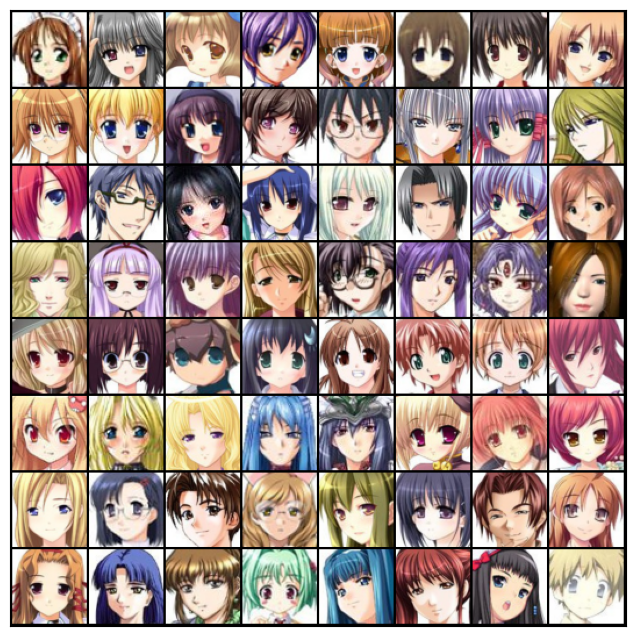

In [4]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [5]:
#Utilize GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    "Wrap a dataloader to move data to a device"
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
print("device: ", device)

train_dl = DeviceDataLoader(train_dl, device)

device:  cuda


In [6]:
#GAN Discriminator network - DCGAN
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #out = 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #out = 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #out = 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #out = 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias = False),
    #out = 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

discriminator = to_device(discriminator, device)


In [7]:
#GAN Generator network - DCGAN

latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out = 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out = 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out = 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out = 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias = False),
    nn.Tanh()
    #out = 3 x 64 x 64
)

generator = to_device(generator, device)


torch.Size([128, 3, 64, 64])


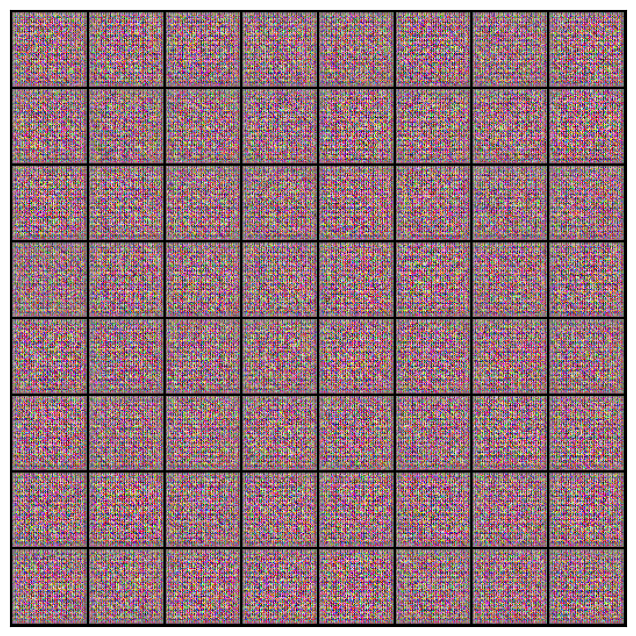

In [8]:
xb = torch.randn(batch_size, latent_size,1,1)   #random latent tensors
xb = to_device(xb, device)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.detach().cpu())

In [9]:
def train_discriminator(real_images, opt_d):
    #Clear discriminator gradients
    opt_d.zero_grad()

    #Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    #Generate fake images
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)

    #Pass fake images trough discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    #Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [10]:
def train_generator(opt_g):
    #Clear generator gradients
    opt_g.zero_grad()

    #Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    #Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    #Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()


In [11]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

def save_samples(index, latent_tensors, show = True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998845..0.99997926].


Saving generated-images-0000.png


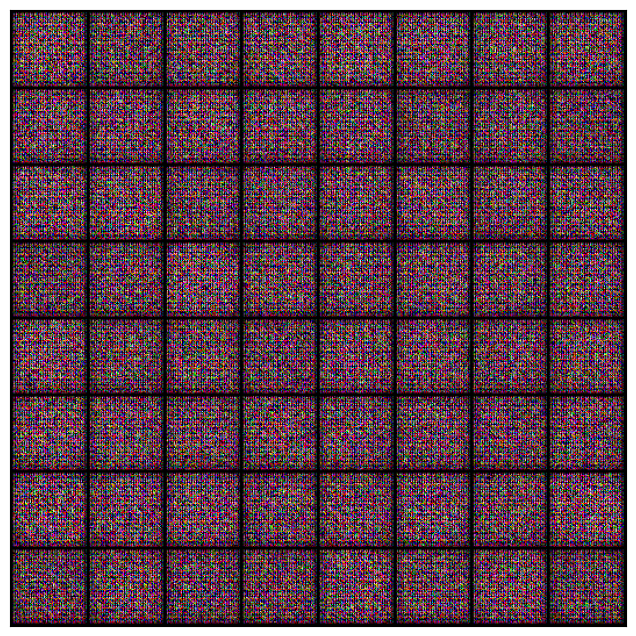

In [12]:
fixed_latent = torch.randn(64, latent_size,1,1,device=device)

save_samples(0,fixed_latent)

In [13]:
from tqdm import tqdm

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    #Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            #Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            #Train generator
            loss_g = train_generator(opt_g)
        
        #Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        #Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                                                            epoch+1,epochs,loss_g, loss_d, real_score, fake_score))
        
        #Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

lr = 0.0002
epochs = 50

history = fit(epochs, lr)

100%|██████████| 178/178 [00:14<00:00, 12.50it/s]


Epoch [1/50], loss_g: 3.2132, loss_d: 0.3643, real_score: 0.9582, fake_score: 0.2572
Saving generated-images-0001.png


100%|██████████| 178/178 [00:14<00:00, 12.58it/s]


Epoch [2/50], loss_g: 8.0071, loss_d: 1.4091, real_score: 0.9684, fake_score: 0.6866
Saving generated-images-0002.png


100%|██████████| 178/178 [00:14<00:00, 12.54it/s]


Epoch [3/50], loss_g: 4.7653, loss_d: 0.4194, real_score: 0.8078, fake_score: 0.1544
Saving generated-images-0003.png


100%|██████████| 178/178 [00:14<00:00, 12.23it/s]


Epoch [4/50], loss_g: 6.1559, loss_d: 0.9419, real_score: 0.9652, fake_score: 0.5523
Saving generated-images-0004.png


100%|██████████| 178/178 [00:14<00:00, 12.38it/s]


Epoch [5/50], loss_g: 6.3508, loss_d: 0.6611, real_score: 0.9130, fake_score: 0.3987
Saving generated-images-0005.png


100%|██████████| 178/178 [00:14<00:00, 12.41it/s]


Epoch [6/50], loss_g: 7.8977, loss_d: 0.6901, real_score: 0.9088, fake_score: 0.4158
Saving generated-images-0006.png


100%|██████████| 178/178 [00:14<00:00, 12.21it/s]


Epoch [7/50], loss_g: 4.9632, loss_d: 0.6072, real_score: 0.7971, fake_score: 0.2674
Saving generated-images-0007.png


100%|██████████| 178/178 [00:14<00:00, 12.47it/s]


Epoch [8/50], loss_g: 9.2999, loss_d: 0.6351, real_score: 0.9527, fake_score: 0.3922
Saving generated-images-0008.png


100%|██████████| 178/178 [00:14<00:00, 12.45it/s]


Epoch [9/50], loss_g: 4.7080, loss_d: 0.4157, real_score: 0.7996, fake_score: 0.1049
Saving generated-images-0009.png


100%|██████████| 178/178 [00:14<00:00, 12.51it/s]


Epoch [10/50], loss_g: 5.5248, loss_d: 0.2106, real_score: 0.8790, fake_score: 0.0672
Saving generated-images-0010.png


100%|██████████| 178/178 [00:14<00:00, 12.40it/s]


Epoch [11/50], loss_g: 4.7857, loss_d: 0.4213, real_score: 0.8433, fake_score: 0.1879
Saving generated-images-0011.png


100%|██████████| 178/178 [00:14<00:00, 12.21it/s]


Epoch [12/50], loss_g: 4.6204, loss_d: 0.1844, real_score: 0.8775, fake_score: 0.0444
Saving generated-images-0012.png


100%|██████████| 178/178 [00:14<00:00, 12.19it/s]


Epoch [13/50], loss_g: 4.4655, loss_d: 0.2350, real_score: 0.8859, fake_score: 0.0913
Saving generated-images-0013.png


100%|██████████| 178/178 [00:14<00:00, 12.36it/s]


Epoch [14/50], loss_g: 4.6667, loss_d: 0.2919, real_score: 0.7855, fake_score: 0.0071
Saving generated-images-0014.png


100%|██████████| 178/178 [00:14<00:00, 12.34it/s]


Epoch [15/50], loss_g: 5.5929, loss_d: 0.2228, real_score: 0.9917, fake_score: 0.1732
Saving generated-images-0015.png


100%|██████████| 178/178 [00:14<00:00, 12.23it/s]


Epoch [16/50], loss_g: 5.7048, loss_d: 0.1996, real_score: 0.9573, fake_score: 0.1344
Saving generated-images-0016.png


100%|██████████| 178/178 [00:14<00:00, 12.21it/s]


Epoch [17/50], loss_g: 7.6580, loss_d: 0.2935, real_score: 0.9643, fake_score: 0.1883
Saving generated-images-0017.png


100%|██████████| 178/178 [00:14<00:00, 12.31it/s]


Epoch [18/50], loss_g: 7.6761, loss_d: 0.1749, real_score: 0.9579, fake_score: 0.1131
Saving generated-images-0018.png


100%|██████████| 178/178 [00:14<00:00, 12.20it/s]


Epoch [19/50], loss_g: 5.1523, loss_d: 0.1818, real_score: 0.8607, fake_score: 0.0011
Saving generated-images-0019.png


100%|██████████| 178/178 [00:14<00:00, 12.21it/s]


Epoch [20/50], loss_g: 5.6136, loss_d: 0.1734, real_score: 0.9125, fake_score: 0.0656
Saving generated-images-0020.png


100%|██████████| 178/178 [00:14<00:00, 12.28it/s]


Epoch [21/50], loss_g: 8.0329, loss_d: 0.1627, real_score: 0.9963, fake_score: 0.1342
Saving generated-images-0021.png


100%|██████████| 178/178 [00:14<00:00, 12.49it/s]


Epoch [22/50], loss_g: 8.0156, loss_d: 0.1591, real_score: 0.9632, fake_score: 0.1070
Saving generated-images-0022.png


100%|██████████| 178/178 [00:14<00:00, 12.43it/s]


Epoch [23/50], loss_g: 5.9819, loss_d: 0.1335, real_score: 0.9065, fake_score: 0.0263
Saving generated-images-0023.png


100%|██████████| 178/178 [00:14<00:00, 12.29it/s]


Epoch [24/50], loss_g: 6.0652, loss_d: 0.1532, real_score: 0.9127, fake_score: 0.0386
Saving generated-images-0024.png


100%|██████████| 178/178 [00:14<00:00, 12.29it/s]


Epoch [25/50], loss_g: 7.2992, loss_d: 0.1148, real_score: 0.9781, fake_score: 0.0849
Saving generated-images-0025.png


100%|██████████| 178/178 [00:14<00:00, 12.14it/s]


Epoch [26/50], loss_g: 5.2283, loss_d: 0.0626, real_score: 0.9730, fake_score: 0.0310
Saving generated-images-0026.png


100%|██████████| 178/178 [00:14<00:00, 12.46it/s]


Epoch [27/50], loss_g: 15.6384, loss_d: 0.3806, real_score: 0.9977, fake_score: 0.2787
Saving generated-images-0027.png


100%|██████████| 178/178 [00:14<00:00, 12.45it/s]


Epoch [28/50], loss_g: 7.3648, loss_d: 0.0220, real_score: 0.9908, fake_score: 0.0121
Saving generated-images-0028.png


100%|██████████| 178/178 [00:14<00:00, 12.63it/s]


Epoch [29/50], loss_g: 10.1426, loss_d: 0.9982, real_score: 0.5139, fake_score: 0.0000
Saving generated-images-0029.png


100%|██████████| 178/178 [00:14<00:00, 12.38it/s]


Epoch [30/50], loss_g: 13.2243, loss_d: 0.3563, real_score: 0.7873, fake_score: 0.0000
Saving generated-images-0030.png


100%|██████████| 178/178 [00:14<00:00, 12.36it/s]


Epoch [31/50], loss_g: 6.5438, loss_d: 0.0773, real_score: 0.9666, fake_score: 0.0337
Saving generated-images-0031.png


100%|██████████| 178/178 [00:14<00:00, 12.45it/s]


Epoch [32/50], loss_g: 8.0593, loss_d: 0.0224, real_score: 0.9810, fake_score: 0.0008
Saving generated-images-0032.png


100%|██████████| 178/178 [00:14<00:00, 12.64it/s]


Epoch [33/50], loss_g: 3.8149, loss_d: 0.5036, real_score: 0.6904, fake_score: 0.0009
Saving generated-images-0033.png


100%|██████████| 178/178 [00:14<00:00, 12.56it/s]


Epoch [34/50], loss_g: 6.2306, loss_d: 0.0976, real_score: 0.9625, fake_score: 0.0520
Saving generated-images-0034.png


100%|██████████| 178/178 [00:14<00:00, 12.40it/s]


Epoch [35/50], loss_g: 8.3929, loss_d: 0.0447, real_score: 0.9598, fake_score: 0.0016
Saving generated-images-0035.png


100%|██████████| 178/178 [00:14<00:00, 12.36it/s]


Epoch [36/50], loss_g: 11.2635, loss_d: 0.0178, real_score: 0.9998, fake_score: 0.0129
Saving generated-images-0036.png


100%|██████████| 178/178 [00:14<00:00, 12.48it/s]


Epoch [37/50], loss_g: 5.4597, loss_d: 0.0994, real_score: 0.9461, fake_score: 0.0368
Saving generated-images-0037.png


100%|██████████| 178/178 [00:14<00:00, 12.39it/s]


Epoch [38/50], loss_g: 5.2465, loss_d: 0.1281, real_score: 0.9230, fake_score: 0.0317
Saving generated-images-0038.png


100%|██████████| 178/178 [00:14<00:00, 12.36it/s]


Epoch [39/50], loss_g: 11.2832, loss_d: 0.1356, real_score: 0.9997, fake_score: 0.1125
Saving generated-images-0039.png


100%|██████████| 178/178 [00:14<00:00, 11.98it/s]


Epoch [40/50], loss_g: 2.9830, loss_d: 0.4352, real_score: 0.7644, fake_score: 0.0004
Saving generated-images-0040.png


100%|██████████| 178/178 [00:15<00:00, 11.43it/s]


Epoch [41/50], loss_g: 5.0511, loss_d: 0.0791, real_score: 0.9422, fake_score: 0.0137
Saving generated-images-0041.png


100%|██████████| 178/178 [00:15<00:00, 11.40it/s]


Epoch [42/50], loss_g: 8.6205, loss_d: 0.0342, real_score: 0.9747, fake_score: 0.0063
Saving generated-images-0042.png


100%|██████████| 178/178 [00:15<00:00, 11.28it/s]


Epoch [43/50], loss_g: 27.7183, loss_d: 0.6572, real_score: 0.9988, fake_score: 0.4204
Saving generated-images-0043.png


100%|██████████| 178/178 [00:15<00:00, 11.35it/s]


Epoch [44/50], loss_g: 4.7516, loss_d: 0.0858, real_score: 0.9430, fake_score: 0.0201
Saving generated-images-0044.png


100%|██████████| 178/178 [00:15<00:00, 11.46it/s]


Epoch [45/50], loss_g: 1.6188, loss_d: 0.3916, real_score: 0.7770, fake_score: 0.0033
Saving generated-images-0045.png


100%|██████████| 178/178 [00:14<00:00, 12.35it/s]


Epoch [46/50], loss_g: 3.5259, loss_d: 0.2077, real_score: 0.8811, fake_score: 0.0536
Saving generated-images-0046.png


100%|██████████| 178/178 [00:14<00:00, 12.45it/s]


Epoch [47/50], loss_g: 5.4102, loss_d: 0.0287, real_score: 0.9973, fake_score: 0.0249
Saving generated-images-0047.png


100%|██████████| 178/178 [00:14<00:00, 11.93it/s]


Epoch [48/50], loss_g: 6.6449, loss_d: 0.0803, real_score: 0.9365, fake_score: 0.0087
Saving generated-images-0048.png


100%|██████████| 178/178 [00:14<00:00, 12.29it/s]


Epoch [49/50], loss_g: 9.3473, loss_d: 0.0723, real_score: 0.9661, fake_score: 0.0204
Saving generated-images-0049.png


100%|██████████| 178/178 [00:14<00:00, 12.32it/s]

Epoch [50/50], loss_g: 7.5114, loss_d: 0.0742, real_score: 0.9789, fake_score: 0.0492
Saving generated-images-0050.png


Text(0.5, 1.0, 'Losses')

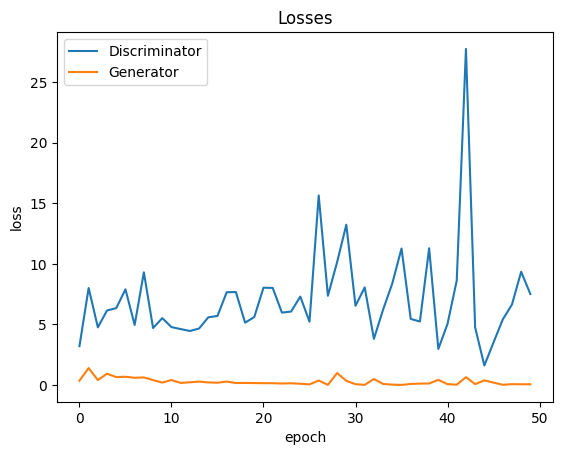

In [14]:
losses_d = history[0]
losses_g = history[1]

plt.plot(losses_d,'-')
plt.plot(losses_g,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

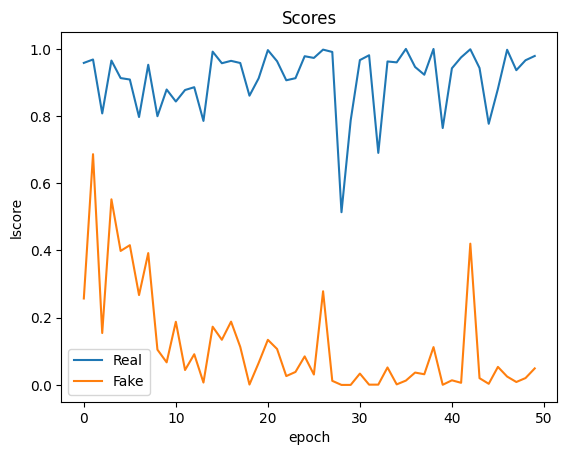

In [15]:
real_scores = history[2]
fake_scores = history[3]

plt.plot(real_scores,'-')
plt.plot(fake_scores,'-')
plt.xlabel('epoch')
plt.ylabel('lscore')
plt.legend(['Real','Fake'])
plt.title('Scores')